In [1]:
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import argparse
import joblib
import os
import sys
import copy
import networkx as nx
from typing import List, Any

from seq_graph_retro.utils.parse import get_reaction_info, extract_leaving_groups, get_attach_atoms
from seq_graph_retro.molgraph import BondEditsRxn, RxnElement, MultiElement
from seq_graph_retro.utils.chem import apply_edits_to_mol, get_mol
from seq_graph_retro.utils import str2bool
from seq_graph_retro.molgraph.mol_features import get_atom_features, onek_encoding_unk,get_bond_features
from seq_graph_retro.data.collate_fns import (pack_graph_feats, prepare_lg_labels,
        tensorize_bond_graphs)
from seq_graph_retro.molgraph.mol_features import BOND_FDIM, ATOM_FDIM, BOND_TYPES, ATOM_LIST
from seq_graph_retro.utils.torch import create_pad_tensor



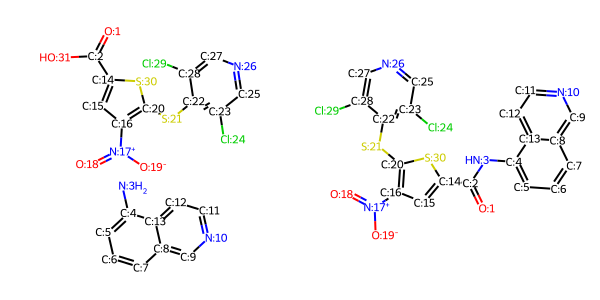

((tensor([[0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0.,

In [5]:
rxn_smi='[NH2:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12.[O:1]=[C:2]([c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1)[OH:31]>>[O:1]=[C:2]([NH:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12)[c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1'
r, p = rxn_smi.split(">>")
products = get_mol(p)
reactants = get_mol(r)
img=Draw.MolsToGridImage([reactants, products], molsPerRow=2, subImgSize=(300, 300))
display(img)
core_edits=['2:3:1.0:0.0']
fragments = apply_edits_to_mol(Chem.Mol(products), core_edits)
tmp_frag = MultiElement(mol=Chem.Mol(fragments)).mols
fragments = Chem.Mol()  #初始化了一个空的分子对象fragments，它将被用来合并其他分子
for mol in tmp_frag:
    fragments = Chem.CombineMols(fragments, mol)
#首先定义BondEditsRxn类
bond_edits_graph = BondEditsRxn(prod_mol=Chem.Mol(products),    #信息都在类中
                                frag_mol=Chem.Mol(fragments),
                                reac_mol=Chem.Mol(reactants),
                                edits_to_apply=core_edits,
                                rxn_class=False)
mol_attrs = ['prod_mol', 'frag_mol']
label_attrs = ['edit_label', 'h_label']
edit_graphs = [bond_edits_graph]
attributes = [graph.get_attributes(mol_attrs=mol_attrs, label_attrs=label_attrs) for graph in edit_graphs]
prod_batch, frag_batch, edit_labels = list(zip(*attributes))
# print(prod_batch)   #RxnElement类
# print(frag_batch)   #MultiElement类
# print(edit_labels)  #这里是一个195*1的向量

fnode = [get_atom_features(Chem.Atom("*"), use_rxn_class=False, rxn_class=0)]
fmess = [[0,0] + [0] * BOND_FDIM]   #获取键特征的向量,8*1
agraph, bgraph = [[]], [[]]
atoms_in_bonds = [[]]   #原子键的列表
atom_scope, bond_scope = [], [] #原子范围和键范围
edge_dict = {}  #边的字典
all_G = []  #所有图

for bid, graph in enumerate(prod_batch):
    mol = graph.mol
    # print(bid)
    # print(graph)
    atom_offset = len(fnode)
    bond_offset = len(atoms_in_bonds)   #键偏移
    bond_to_tuple = {bond.GetIdx(): tuple(sorted((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())))
                             for bond in mol.GetBonds()}
    tuple_to_bond = {val: key for key, val in bond_to_tuple.items()}
    # print(tuple_to_bond)

    atom_scope.append(graph.update_atom_scope(atom_offset)) #[(98,30)]，第一维加上了98的偏移
    bond_scope.append(graph.update_bond_scope(bond_offset)) #[(0,33)]

    G = nx.convert_node_labels_to_integers(graph.G_dir, first_label=atom_offset)
    all_G.append(G)   #将有向图添加到all_G中
    fnode.extend( [None for v in G.nodes] )
    # print(fnode)
    # print(len(fnode))
    # print(G.nodes)
    for v, attr in G.nodes(data='label'):
        # print(v, attr)
        G.nodes[v]['batch_id'] = bid
        fnode[v] = get_atom_features(mol.GetAtomWithIdx(v-atom_offset),
                                        use_rxn_class=False,
                                        rxn_class=graph.rxn_class)
        agraph.append([])
    # for i in fnode:
    #     print(i)
    bond_comp = [None for _ in range(mol.GetNumBonds())]    #键的列表，1*33
    for u, v, attr in G.edges(data='label'):
        # print(u, v, attr)
        bond_feat = get_bond_features(mol.GetBondBetweenAtoms(u-atom_offset, v-atom_offset)).tolist()

        bond = sorted([u, v])
        mess_vec = [u, v] + bond_feat
        # print(mess_vec)
        if [v, u] not in bond_comp: #如果[v,u]不在键的列表中,键是两个原子之间的连接，它不区分方向，即键 [v, u] 和 [u, v] 表示的是同一条键
            idx_to_add = tuple_to_bond[(u-atom_offset, v-atom_offset)]  #获取键的索引
            bond_comp[idx_to_add] = [u, v]  #将键的两个原子添加到键的列表中

        fmess.append(mess_vec)  #每个键都有一个8*1的特征向量，最终变成8*67的特征向量
        edge_dict[(u, v)] = eid = len(edge_dict) + 1
        G[u][v]['mess_idx'] = eid
        agraph[v].append(eid)   #将键的索引添加到原子的邻接表中
        bgraph.append([])
    atoms_in_bonds.extend(bond_comp)
    # print(atoms_in_bonds)
    # print(len(atoms_in_bonds))
    for u, v in G.edges:
        eid = edge_dict[(u, v)]
        for w in G.predecessors(u):
            # print(w)
            if w == v: continue
            bgraph[eid].append( edge_dict[(w, u)] )
        
fnode = torch.tensor(fnode, dtype=torch.float)
fmess = torch.tensor(fmess, dtype=torch.float)
# print(fnode)
# print(fmess)
atoms_in_bonds = create_pad_tensor(atoms_in_bonds).long()
agraph = create_pad_tensor(agraph)
bgraph = create_pad_tensor(bgraph)
# print(agraph)
# print(bgraph)
# print(atoms_in_bonds)

graph_tensors = (fnode, fmess, agraph, bgraph, atoms_in_bonds)
scopes = (atom_scope, bond_scope)   #atom_scope:[(1,30)]，第一维加上了98的偏移；bond_scope:[(1,33)]
# print(graph_tensors)
# print(scopes)

directed = True
prod_inputs = pack_graph_feats(prod_batch, directed=directed, use_rxn_class=False)
frag_inputs = pack_graph_feats(frag_batch, directed=directed, use_rxn_class=False)
bond_graph_inputs = tensorize_bond_graphs(prod_batch, directed=directed, use_rxn_class=False)
# print(prod_inputs)
# print(frag_inputs)
print(bond_graph_inputs)


# get_reaction_info函数信息

ReactionInfo(rxn_smi='[NH2:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12.[O:1]=[C:2]([c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1)[OH:31]>>[O:1]=[C:2]([NH:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12)[c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1', core={2, 3}, core_edits=['2:3:1.0:0.0'], lg_edits=['2:31:0.0:1.0'], attach_atoms=[[1], []], rxn_class=6)
rxn_smi:[NH2:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12.[O:1]=[C:2]([c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1)[OH:31]>>[O:1]=[C:2]([NH:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12)[c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1
core:{2, 3}
core_ed

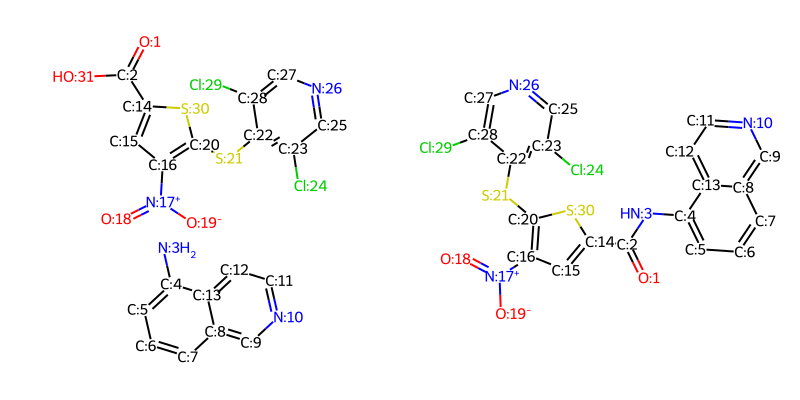

In [12]:
rxn_smi='[NH2:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12.[O:1]=[C:2]([c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1)[OH:31]>>[O:1]=[C:2]([NH:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:10][cH:11][cH:12][c:13]12)[c:14]1[cH:15][c:16]([N+:17](=[O:18])[O-:19])[c:20]([S:21][c:22]2[c:23]([Cl:24])[cH:25][n:26][cH:27][c:28]2[Cl:29])[s:30]1'
r, p = rxn_smi.split(">>")
rxn_class=6
reaction_info = get_reaction_info(rxn_smi, kekulize=True,use_h_labels=True,rxn_class=rxn_class)
print(reaction_info)
attributes = ['rxn_smi', 'core', 'core_edits', 'lg_edits', 'attach_atoms', 'rxn_class']
# 遍历属性列表并打印
for attr in attributes:
    value = getattr(reaction_info, attr)
    print(f"{attr}:{value}")

#绘图
smiles=[r,p]
mol=[Chem.MolFromSmiles(s) for s in smiles]
img = Draw.MolsToGridImage(mol,molsPerRow=2,subImgSize=(400,400))
display(img)

# RxnElement类测试

In [21]:
import networkx as nx

prod_mol=Chem.MolFromSmiles(p)   #产物的mol

G_undir = nx.Graph(Chem.rdmolops.GetAdjacencyMatrix(prod_mol))
G_dir = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(prod_mol))
print('无向图节点：',G_undir.nodes())
print('无向图的边：',G_undir.edges())
print('有向图节点：',G_dir.nodes())
print('有向图的边：',G_dir.edges())
for atom in prod_mol.GetAtoms():
    # print(atom.GetSymbol())
    G_undir.nodes[atom.GetIdx()]['label'] = atom.GetSymbol()
    G_dir.nodes[atom.GetIdx()]['label'] = atom.GetSymbol()
BOND_TYPES = [None, Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, \
    Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
for bond in prod_mol.GetBonds():    #设置的图的边（化学键）
    a1 = bond.GetBeginAtom().GetIdx()   #获取键的开始原子的索引
    a2 = bond.GetEndAtom().GetIdx()     #获取键的结束原子的索引
    btype = BOND_TYPES.index( bond.GetBondType() )
    # print(a1,a2,btype)
atom_scope = (0, 30)
print(atom_scope)


无向图节点： [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
无向图的边： [(0, 1), (1, 2), (1, 13), (2, 3), (3, 4), (3, 12), (4, 5), (5, 6), (6, 7), (7, 8), (7, 12), (8, 9), (9, 10), (10, 11), (11, 12), (13, 14), (13, 29), (14, 15), (15, 16), (15, 19), (16, 17), (16, 18), (19, 20), (19, 29), (20, 21), (21, 22), (21, 27), (22, 23), (22, 24), (24, 25), (25, 26), (26, 27), (27, 28)]
有向图节点： [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
有向图的边： [(0, 1), (1, 0), (1, 2), (1, 13), (2, 1), (2, 3), (3, 2), (3, 4), (3, 12), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6), (7, 8), (7, 12), (8, 7), (8, 9), (9, 8), (9, 10), (10, 9), (10, 11), (11, 10), (11, 12), (12, 3), (12, 7), (12, 11), (13, 1), (13, 14), (13, 29), (14, 13), (14, 15), (15, 14), (15, 16), (15, 19), (16, 15), (16, 17), (16, 18), (17, 16), (18, 16), (19, 15), (19, 20), (19, 29), (20, 19), (20, 21), (21, 20), (21,

# get_reaction_info()函数的实现

### get_bond_info(): 获取分子中的键信息函数

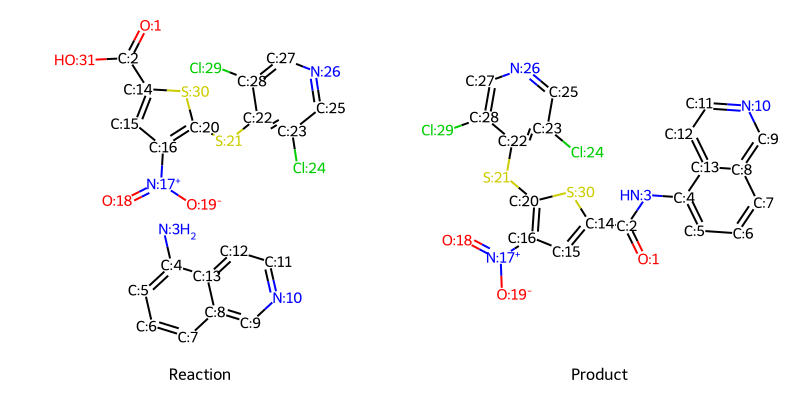

产物分子键数量： 33
产物分子原子数： 30
DOUBLE
SINGLE
SINGLE
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
SINGLE
AROMATIC
AROMATIC
SINGLE
DOUBLE
SINGLE
AROMATIC
SINGLE
SINGLE
AROMATIC
SINGLE
AROMATIC
AROMATIC
AROMATIC
AROMATIC
SINGLE
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
p_amap_idx: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29}


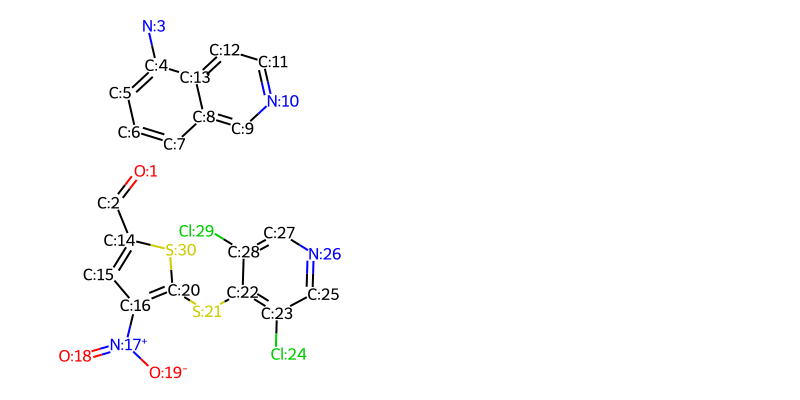

attach_atoms: [[1], []]
r_bond_info: {(3, 4): [1.0, 0], (4, 5): [1.5, 1], (5, 6): [1.5, 2], (6, 7): [1.5, 3], (7, 8): [1.5, 4], (8, 9): [1.5, 5], (9, 10): [1.5, 6], (10, 11): [1.5, 7], (11, 12): [1.5, 8], (12, 13): [1.5, 9], (1, 2): [2.0, 10], (2, 14): [1.0, 11], (14, 15): [1.5, 12], (15, 16): [1.5, 13], (16, 17): [1.0, 14], (17, 18): [2.0, 15], (17, 19): [1.0, 16], (16, 20): [1.5, 17], (20, 21): [1.0, 18], (21, 22): [1.0, 19], (22, 23): [1.5, 20], (23, 24): [1.0, 21], (23, 25): [1.5, 22], (25, 26): [1.5, 23], (26, 27): [1.5, 24], (27, 28): [1.5, 25], (28, 29): [1.0, 26], (20, 30): [1.5, 27], (2, 31): [1.0, 28], (4, 13): [1.5, 29], (14, 30): [1.5, 30], (8, 13): [1.5, 31], (22, 28): [1.5, 32]}
p_bond_info: {(1, 2): [2.0, 0], (2, 3): [1.0, 1], (3, 4): [1.0, 2], (4, 5): [1.5, 3], (5, 6): [1.5, 4], (6, 7): [1.5, 5], (7, 8): [1.5, 6], (8, 9): [1.5, 7], (9, 10): [1.5, 8], (10, 11): [1.5, 9], (11, 12): [1.5, 10], (12, 13): [1.5, 11], (2, 14): [1.0, 12], (14, 15): [1.5, 13], (15, 16): [1.5, 14

In [9]:
from typing import List, Dict, Tuple, Set
from collections import namedtuple, deque
ReactionInfo = namedtuple("ReactionInfo", ['rxn_smi', 'core', 'core_edits', 'lg_edits', 'attach_atoms', 'rxn_class'])
from seq_graph_retro.utils.chem import apply_edits_to_mol, get_mol, get_sub_mol
from seq_graph_retro.molgraph.mol_features import BOND_FLOAT_TO_TYPE
from seq_graph_retro.molgraph import MultiElement
def get_bond_info(mol: Chem.Mol) -> Dict:   #此函数获得分子中键的信息
    if mol is None:
        return {}

    bond_info = {}
    for bond in mol.GetBonds():
        a_start = bond.GetBeginAtom().GetAtomMapNum()
        a_end = bond.GetEndAtom().GetAtomMapNum()

        key_pair = sorted([a_start, a_end])
        bond_info[tuple(key_pair)] = [bond.GetBondTypeAsDouble(), bond.GetIdx()]

    return bond_info
r, p = rxn_smi.split(">>")

#绘图
smiles=[r,p]
mol=[Chem.MolFromSmiles(s) for s in smiles]
img = Draw.MolsToGridImage(mol,molsPerRow=2,subImgSize=(400,400),legends=['Reaction','Product'])
display(img)

reac_mol = get_mol(r)   #得到mol表达，其中，苯环的键变为单双键交替
prod_mol = get_mol(p)
print("产物分子键数量：",prod_mol.GetNumBonds())
print("产物分子原子数：",prod_mol.GetNumAtoms())
for bond in prod_mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        print(bond.GetBondType())
        
#GetAtomMapNum():原子中的标识符，可以画在图片中，只有存在才会返回，不会再则为0
#GetIdx():原子的默认索引号，从0开始，每个原子都会有，逐渐+1
p_amap_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in prod_mol.GetAtoms()}
print('p_amap_idx:',p_amap_idx)

#测试apply_edits_to_mol函数
fragments = apply_edits_to_mol(prod_mol, ['2:3:1.0:0.0'])
img = Draw.MolsToGridImage([fragments],molsPerRow=2,subImgSize=(400,400))
display(img)

#测试get_attach_atoms函数
attach_atoms = get_attach_atoms(rxn_smi=rxn_smi, core_edits=['2:3:1.0:0.0'], core={2, 3})
print('attach_atoms:',attach_atoms)

#获取键信息
p_bond_info=get_bond_info(prod_mol)
r_bond_info=get_bond_info(reac_mol)
print('r_bond_info:',r_bond_info)
print('p_bond_info:',p_bond_info)

# BOND_TYPES = [None, Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, \
#     Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
# BOND_FLOAT_TO_TYPE = {
#     0.0: BOND_TYPES[0], 无键
#     1.0: BOND_TYPES[1], 单键
#     2.0: BOND_TYPES[2], 双键
#     3.0: BOND_TYPES[3], 三键
#     1.5: BOND_TYPES[4], 苯环键
# }

### get_reaction_core函数的实现：获取给定反应的反应和编辑中心core_edits和rxn_core

In [8]:
#确保在化学反应中，反应物（reactants）和产物（product）之间在芳香环上的键序保持一致。
#处理了从芳香性结构转换为Kekulé结构时，保持原有芳香环中未改变键的键序相同的问题
def align_kekule_pairs(r: str, p: str) -> Tuple[Chem.Mol, Chem.Mol]:
    reac_mol = Chem.MolFromSmiles(r)
    max_amap = max([atom.GetAtomMapNum() for atom in reac_mol.GetAtoms()])
    for atom in reac_mol.GetAtoms():
        if atom.GetAtomMapNum() == 0:
            atom.SetAtomMapNum(max_amap + 1)
            max_amap = max_amap + 1

    prod_mol = Chem.MolFromSmiles(p)

    prod_prev = get_bond_info(prod_mol)
    Chem.Kekulize(prod_mol)
    prod_new = get_bond_info(prod_mol)

    reac_prev = get_bond_info(reac_mol)
    Chem.Kekulize(reac_mol)
    reac_new = get_bond_info(reac_mol)

    for bond in prod_new:
        if bond in reac_new and (prod_prev[bond][0] == reac_prev[bond][0]):
            reac_new[bond][0] = prod_new[bond][0]

    reac_mol = Chem.RWMol(reac_mol)
    amap_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in reac_mol.GetAtoms()}

    for bond in reac_new:
        idx1, idx2 = amap_idx[bond[0]], amap_idx[bond[1]]
        bo = reac_new[bond][0]
        reac_mol.RemoveBond(idx1, idx2)
        reac_mol.AddBond(idx1, idx2, BOND_FLOAT_TO_TYPE[bo])

    return reac_mol.GetMol(), prod_mol

#获取给定反应的反应和编辑中心
def get_reaction_core(r: str, p: str, kekulize: bool = False, use_h_labels: bool = False) -> Tuple[Set, List]:
    reac_mol = get_mol(r)
    prod_mol = get_mol(p)

    if reac_mol is None or prod_mol is None:
        return set(), []

    if kekulize:
        reac_mol, prod_mol = align_kekule_pairs(r, p)
    #得到产物键的信息和原子标号信息
    prod_bonds = get_bond_info(prod_mol)
    p_amap_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in prod_mol.GetAtoms()}

    #这里给反应物中每个原子标上序号，为了更好地获取反应物中键的信息
    max_amap = max([atom.GetAtomMapNum() for atom in reac_mol.GetAtoms()])
    for atom in reac_mol.GetAtoms():
        if atom.GetAtomMapNum() == 0:
            atom.SetAtomMapNum(max_amap + 1)
            max_amap += 1
    #得到反应物键的信息和原子标号信息
    reac_bonds = get_bond_info(reac_mol)
    reac_amap = {atom.GetAtomMapNum(): atom.GetIdx() for atom in reac_mol.GetAtoms()}

    rxn_core = set()
    core_edits = []

    for bond in prod_bonds: #遍历product中的所有键
        #产物中的键在反应物中，并且键的类型不相等，说明该键类型改变了，更新到core_edits和rxn_core中
        if bond in reac_bonds and prod_bonds[bond][0] != reac_bonds[bond][0]:
            a_start, a_end = bond
            prod_bo, reac_bo = prod_bonds[bond][0], reac_bonds[bond][0]

            a_start, a_end = sorted([a_start, a_end])
            edit = f"{a_start}:{a_end}:{prod_bo}:{reac_bo}"
            core_edits.append(edit)
            rxn_core.update([a_start, a_end])
        #产物中的键不在反应物中，说明该键断开了，更新到core_edits和rxn_core中
        if bond not in reac_bonds:
            a_start, a_end = bond
            reac_bo = 0.0
            prod_bo = prod_bonds[bond][0]

            start, end = sorted([a_start, a_end])
            edit = f"{a_start}:{a_end}:{prod_bo}:{reac_bo}"
            core_edits.append(edit)
            rxn_core.update([a_start, a_end])

    for bond in reac_bonds: #遍历反应物的键
        #如果反应物中有键不再产物中，说明是新加入的键
        if bond not in prod_bonds:
            amap1, amap2 = bond
            #此时说明新加的键两边的原子都在产物中，说明是合键，也加入core_edits和rxn_core中
            #这里reactions中多出的键就不需要了，因为不涉及products中的键
            if (amap1 in p_amap_idx) and (amap2 in p_amap_idx):
                a_start, a_end = sorted([amap1, amap2])
                reac_bo = reac_bonds[bond][0]
                edit = f"{a_start}:{a_end}:{0.0}:{reac_bo}"
                core_edits.append(edit)
                rxn_core.update([a_start, a_end])

    if use_h_labels:    #是否使用h_labels,这里是使用
        if len(rxn_core) == 0:
            for atom in prod_mol.GetAtoms():
                amap_num = atom.GetAtomMapNum()
                #计算产物和反应物这个atom的氢原子数量
                numHs_prod = atom.GetTotalNumHs()
                numHs_reac = reac_mol.GetAtomWithIdx(reac_amap[amap_num]).GetTotalNumHs()
                #如果这个atom的氢原子数量不一致，则加入core_edits和rxn_core中
                if numHs_prod != numHs_reac:
                    edit = f"{amap_num}:{0}:{1.0}:{0.0}"
                    core_edits.append(edit)
                    rxn_core.add(amap_num)

    return rxn_core, core_edits

r, p = rxn_smi.split(">>")
reac_mol = get_mol(r)   #得到mol表达，其中，苯环的键变为单双键交替
prod_mol = get_mol(p)

rxn_core, core_edits = get_reaction_core(r, p, kekulize=True, use_h_labels=True)